<a href="https://colab.research.google.com/github/aslla77/practice-Python/blob/main/2nd/20_LSTM_use_STOCK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM
- 장기적으로 가면 Simple RNN은 입력데이터가 많을 수록 은닉층에서 보관하는 과거 정보의 데이터가 작아진다
- 이러한 문제를 해결하기 위해 LSTM이 등장 하였다.

#LSTM의 구조
- LSTM 핵심은 이전  단계 정보를 memory coll에 저장하여 다음 단계로 전달하는 것임

- forget gate(과거의 정보를 얼마나 잊을지 )> input gate(현재의 정보를 얼마나 반영할지)> output gate(현재 레이어의 아웃풋 값 계산)



##forget gate
- $F_t=sigmoid(U_fX_t+W_fH_{t-1}+b_f$
- $F_t$가 1에 가까우면 많이 과거의 정보를 가져가겠다.
- 0에 가까우면 과거의 정보를 많이 활용하지 않겠다

##input gate
- $\overset{\sim}{C_t}=tanh(U_CX_t+W_CH_{t-1}+b_C)$
  - 현재 시점의 데이터 $X_t$와 과거 은닉층 값 $H_{t-1}$에 각각의 가중치$W_C,U_C$곱하여 더한 뒤에 tanh 함수를 적용하여 현재 시점의 새로운 정보를 생성

- $I_t=sigmoid(U_{in}X_t+W_{in}H_{t-1}+b_i)$
  - 현재 시점의 데이터 $X_t$와 과거의 은닉층 값 $H_{t-1}$에 각각 가중치 $W_{in},U_{in}$을 곱하고 더한 결과에 sigmoid함수를 적용하여, 어떤 정보를 업데이트 할 지 결정

##cell state
- $C_t=F_tC_{t-1}+I_t\overset{\sim}{C_t}$
  - $F_tC_{t-1}$는 과거의 정보를 계산된 만큼 기억하거나 잊어버리고
  - $I_t\overset{\sim}{C_t}$는 현재 시점의 중요도

##output gate
- $H_t=O_t*tanh(C_t)$
- $O_t= sigmoid(U_OX_t+W_OH_{t-1}+b_O$

#LSTM 활용을 이용한 삼성전자의 주식 가격 예측



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
#20년치 데이터 불러오기
raw_df=pd.read_csv('/content/drive/MyDrive/005930.KS.csv')

raw_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-08-12,6380.0,6420.0,6260.0,6340.0,4797.509766,38830000
1,2002-08-13,6340.0,6490.0,6340.0,6490.0,4911.016113,19635000
2,2002-08-14,6440.0,6460.0,6360.0,6440.0,4873.179199,35980000
3,2002-08-15,6440.0,6440.0,6440.0,6440.0,4873.179199,0
4,2002-08-16,6600.0,6660.0,6500.0,6510.0,4926.148926,31750000


In [3]:
#3일 평균이동선과 5일 평균이동선 생성
ma5 = raw_df['Adj Close'].rolling(window=5).mean()
ma3 = raw_df['Adj Close'].rolling(window=3).mean()

raw_df.insert(len(raw_df.columns), "3MA", ma3)
raw_df.insert(len(raw_df.columns), "5MA", ma5)
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2002-08-12,6380.0,6420.0,6260.0,6340.0,4797.509766,38830000,NaN,NaN
1,2002-08-13,6340.0,6490.0,6340.0,6490.0,4911.016113,19635000,NaN,NaN
2,2002-08-14,6440.0,6460.0,6360.0,6440.0,4873.179199,35980000,4860.568359,NaN
3,2002-08-15,6440.0,6440.0,6440.0,6440.0,4873.179199,0,4885.791504,NaN
4,2002-08-16,6600.0,6660.0,6500.0,6510.0,4926.148926,31750000,4890.835775,4876.206641


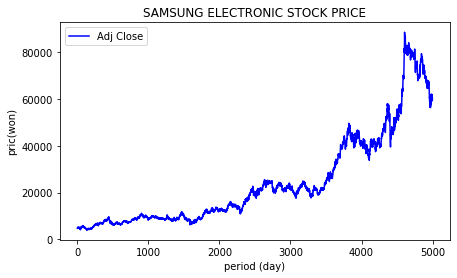

In [4]:
plt.figure(figsize=(7,4))

plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('pric(won)')
plt.xlabel('period (day)')

plt.plot(raw_df['Adj Close'],label='Adj Close',color='b')
plt.legend(loc='best')
plt.show()
#LSTM 이용하여 20년간 의 주가 데이터 학습 그리고 예측

In [5]:
#데이터 전처리 Outlier
raw_df.describe()
#값이 0 인 부분 존재 공휴일이나 쉬는 날 경우

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4.999000e+03,4997.000000,4995.000000
mean,27971.738348,28245.741148,27689.641928,27965.099020,24444.469299,1.892887e+07,24441.258091,24438.128829
std,20181.532014,20348.866407,20006.803580,20165.145005,19998.217516,1.075730e+07,19991.082290,19984.617718
min,5320.000000,5460.000000,5190.000000,5390.000000,4078.639648,0.000000e+00,4111.430176,4133.122559
25%,11700.000000,11820.000000,11580.000000,11700.000000,8974.521484,1.142215e+07,8979.637044,8980.575098
50%,23060.000000,23360.000000,22820.000000,23080.000000,19004.511719,1.639900e+07,19012.655599,19041.658203
75%,42500.000000,42925.000000,41980.000000,42525.000000,38030.550782,2.369498e+07,38166.986979,38170.540235
max,90300.000000,96800.000000,89500.000000,91000.000000,88367.843750,9.072000e+07,87817.565104,87357.921875


In [6]:
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          2
5MA          4
dtype: int64

In [7]:
#NaN값의 위치 확인
raw_df.loc[raw_df['5MA'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2002-08-12,6380.0,6420.0,6260.0,6340.0,4797.509766,38830000,NaN,NaN
1,2002-08-13,6340.0,6490.0,6340.0,6490.0,4911.016113,19635000,NaN,NaN
2,2002-08-14,6440.0,6460.0,6360.0,6440.0,4873.179199,35980000,4860.568359,NaN
3,2002-08-15,6440.0,6440.0,6440.0,6440.0,4873.179199,0,4885.791504,NaN


In [8]:
#Volume값에서 0인 부분을 NaN으로 대체
raw_df['Volume']=raw_df['Volume'].replace(0,np.nan)
raw_df.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume       73
3MA           2
5MA           4
dtype: int64

In [9]:
raw_df=raw_df.dropna()
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [10]:
#정규화
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

scale_cols=['Open','High','Low','Close','Adj Close',
            '3MA','5MA','Volume']

scaled_df=scaler.fit_transform(raw_df[scale_cols])

print(type(scaled_df),'\n')

scaled_df= pd.DataFrame(scaled_df,columns=scale_cols)

print(scaled_df)

<class 'numpy.ndarray'> 

          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.015062  0.013138  0.015538  0.013083   0.010055  0.009311  0.008929   
1     0.015533  0.013576  0.016368  0.014835   0.011401  0.009974  0.009511   
2     0.017416  0.016203  0.018740  0.017872   0.013736  0.011421  0.010292   
3     0.018828  0.016860  0.019689  0.018806   0.014454  0.012897  0.011311   
4     0.020240  0.017517  0.020638  0.018222   0.014005  0.013771  0.012238   
...        ...       ...       ...       ...        ...       ...       ...   
4918  0.659920  0.612437  0.657217  0.647237   0.672937  0.682808  0.687618   
4919  0.650506  0.604773  0.645356  0.637893   0.663446  0.676835  0.683533   
4920  0.630501  0.588351  0.633495  0.627380   0.652769  0.667278  0.678246   
4921  0.638739  0.597110  0.641798  0.636725   0.662260  0.663694  0.674401   
4922  0.637562  0.604773  0.642984  0.640229   0.665819  0.664490  0.671277   

        Volume  
0     0.

In [11]:
#입력 데이터와 정답 데이터 정의 후 numpyfh 변환하여 데이터 전처리 과정을 완료함

feature_cols=['3MA','5MA','Adj Close']# 입력 데이터
label_cols=['Adj Close'] #정답 데이터

label_df=pd.DataFrame(scaled_df,columns=label_cols)
feature_df=pd.DataFrame(scaled_df,columns=feature_cols)

print(feature_df)
print(label_df)

label_np=label_df.to_numpy()
feature_np=feature_df.to_numpy()

           3MA       5MA  Adj Close
0     0.009311  0.008929   0.010055
1     0.009974  0.009511   0.011401
2     0.011421  0.010292   0.013736
3     0.012897  0.011311   0.014454
4     0.013771  0.012238   0.014005
...        ...       ...        ...
4918  0.682808  0.687618   0.672937
4919  0.676835  0.683533   0.663446
4920  0.667278  0.678246   0.652769
4921  0.663694  0.674401   0.662260
4922  0.664490  0.671277   0.665819

[4923 rows x 3 columns]
      Adj Close
0      0.010055
1      0.011401
2      0.013736
3      0.014454
4      0.014005
...         ...
4918   0.672937
4919   0.663446
4920   0.652769
4921   0.662260
4922   0.665819

[4923 rows x 1 columns]


In [12]:
#딥러닝 과정
def make_sequene_dataset(feature,label,window_size): #입력 파라미터

  feature_list=[]
  label_list=[]

  for i in range(len(feature)-window_size):

    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])

  return np.array(feature_list),np.array(label_list)

window_size=40

X,Y=make_sequene_dataset(feature_np,label_np,window_size)

print(X.shape,Y.shape)

(4883, 40, 3) (4883, 1)


In [13]:
split=-200

x_train=X[0:split]
y_train=Y[0:split]

x_test=X[split:]
y_test=Y[split:]

model=Sequential()

model.add(LSTM(128,
               activation='tanh',
               input_shape=x_train[0].shape))

model.add(Dense(1,activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse',optimizer='adam',metrics=['mae'])

early_stop=EarlyStopping(monitor='val_loss',patience=5)

model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=16,callbacks=[early_stop])

Epoch 1/100
293/293 [==============================] - 10s 6ms/step - loss: 0.0017 - mae: 0.0151 - val_loss: 0.0012 - val_mae: 0.0287
Epoch 2/100
293/293 [==============================] - 1s 5ms/step - loss: 1.6443e-04 - mae: 0.0080 - val_loss: 6.4062e-04 - val_mae: 0.0201
Epoch 3/100
293/293 [==============================] - 1s 5ms/step - loss: 1.4205e-04 - mae: 0.0074 - val_loss: 3.7364e-04 - val_mae: 0.0146
Epoch 4/100
293/293 [==============================] - 2s 5ms/step - loss: 1.5301e-04 - mae: 0.0078 - val_loss: 4.7233e-04 - val_mae: 0.0172
Epoch 5/100
293/293 [==============================] - 2s 5ms/step - loss: 1.2067e-04 - mae: 0.0069 - val_loss: 4.9204e-04 - val_mae: 0.0180
Epoch 6/100
293/293 [==============================] - 2s 5ms/step - loss: 1.2791e-04 - mae: 0.0072 - val_loss: 2.7403e-04 - val_mae: 0.0127
Epoch 7/100
293/293 [==============================] - 2s 5ms/step - loss: 1.0697e-04 - mae: 0.0066 - val_loss: 2.7876e-04 - val_mae: 0.0131
Epoch 8/100
293/293 

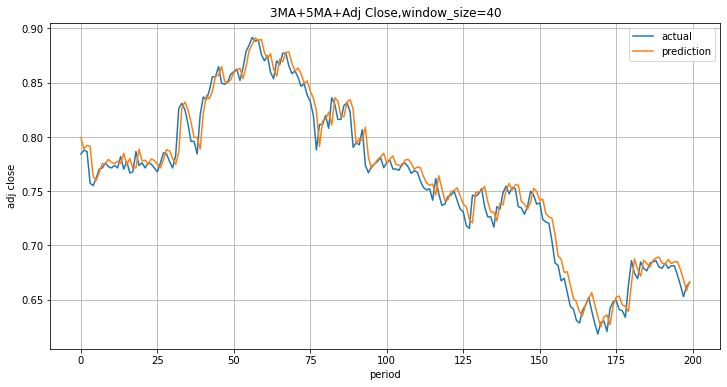

In [16]:
pred= model.predict(x_test)

plt.figure(figsize=(12,6))
plt.title('3MA+5MA+Adj Close,window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()